# Jet Compression using an Autoencoder

In [1]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

In [5]:
print(train.shape, test.shape)

(1550321, 4) (387581, 4)


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 3.00000e+00, 1.04030e+04, 3.59260e+04, 3.38000e+04,
        2.72110e+04, 2.97320e+04, 3.06360e+04, 2.32380e+04, 1.95780e+04,
        1.89540e+04, 2.23020e+04, 3.10100e+04, 5.19450e+04, 7.94390e+04,
        1.00168e+05, 1.11372e+05, 1.07613e+05, 9.42850e+04, 8.18850e+04,
        7.18760e+04, 6.30080e+04, 5.41930e+04, 4.69800e+04, 4.12230e+04,
        3.54680e+04, 3.08500e+04, 2.68230e+04, 2.36560e+04, 2.17670e+04,
        2.05710e+04, 2.20510e+04, 2.32450e+04, 2.23020e+04, 1.97450e+04,
        1.62720e+04, 1.41620e+04, 1.16070e+04, 9.93

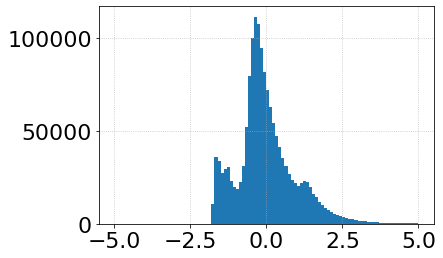

In [6]:
plt.hist(train['pT'], bins=100, range=(-5, 5))

## Training

In [7]:
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

In [8]:
nodes = [4,8,6,4,3,4,6,8,4]
n_layers = len(nodes)
nodes[(n_layers // 2)]

ins_n_outs = []
en_modulelist = nn.ModuleList()
de_modulelist = nn.ModuleList()
for ii in range(n_layers // 2):
    ins = nodes[ii]
    outs = nodes[ii + 1]
    ins_n_outs.append((ins, outs))
    en_modulelist.append(nn.Linear(ins, outs))
    en_modulelist.append(nn.Tanh())
for ii in range(n_layers // 2):
    ii += n_layers // 2
    ins = nodes[ii]
    outs = nodes[ii + 1]
    de_modulelist.append(nn.Linear(ins, outs))
    de_modulelist.append(nn.Tanh())
    
    
encoder = nn.Sequential(en_modulelist)

decoder = nn.Sequential(de_modulelist)

In [45]:
curr_param_string = ''
for ii in nodes:
                curr_param_string = curr_param_string + '_%d' %ii

In [46]:
curr_param_string

'_4_8_6_4_3_4_6_8_4'

In [47]:
tmp = 'abcd'

In [49]:
tmp[:-1]

'abc'

In [9]:
encoder

Sequential(
  (0): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): Tanh()
    (6): Linear(in_features=4, out_features=3, bias=True)
    (7): Tanh()
  )
)

In [10]:
decoder

Sequential(
  (0): ModuleList(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): Tanh()
  )
)

In [33]:
class AE_bn(nn.Module):
    def __init__(self, nodes, no_last_bias=False):
        super(AE_bn, self).__init__()
        n_layers = len(nodes)
        ins_n_outs = []
        en_modulelist = nn.ModuleList()
        de_modulelist = nn.ModuleList()
        for ii in range(n_layers // 2):
            ins = nodes[ii]
            outs = nodes[ii + 1]
            ins_n_outs.append((ins, outs))
            en_modulelist.append(nn.Linear(ins, outs))
            en_modulelist.append(nn.Tanh())
            en_modulelist.append(nn.BatchNorm1d(outs))
        for ii in range(n_layers // 2):
            ii += n_layers // 2
            ins = nodes[ii]
            outs = nodes[ii + 1]
            de_modulelist.append(nn.Linear(ins, outs))
            de_modulelist.append(nn.Tanh())
            de_modulelist.append(nn.BatchNorm1d(outs))
            
        de_modulelist = de_modulelist[:-2]  # Remove Tanh activation and BatchNorm1d from output layer
        if no_last_bias:
            de_modulelist = de_modulelist[:-1]
            de_modulelist.append(nn.Linear(nodes[-2], nodes[-1], bias=False))


        self.encoder = nn.Sequential(*en_modulelist)

        self.decoder = nn.Sequential(*de_modulelist)
    
    def encode(self, x):
        return self.encoder(x)
        
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [34]:
myAE = AE_bn(nodes, no_last_bias=True)
myAE

AE_bn(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=8, out_features=6, bias=True)
    (4): Tanh()
    (5): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=6, out_features=4, bias=True)
    (7): Tanh()
    (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=4, out_features=3, bias=True)
    (10): Tanh()
    (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=4, out_features=6, bias=True)
    (4): Tanh()
    (5): BatchNorm1d(6, eps=1e-05, momentum=0.1, affi

In [35]:
class AE_basic(nn.Module):
    def __init__(self, nodes, no_last_bias=False):
        super(AE_basic, self).__init__()
        n_layers = len(nodes)
        ins_n_outs = []
        en_modulelist = nn.ModuleList()
        de_modulelist = nn.ModuleList()
        for ii in range(n_layers // 2):
            ins = nodes[ii]
            outs = nodes[ii + 1]
            ins_n_outs.append((ins, outs))
            en_modulelist.append(nn.Linear(ins, outs))
            en_modulelist.append(nn.Tanh())
        for ii in range(n_layers // 2):
            ii += n_layers // 2
            ins = nodes[ii]
            outs = nodes[ii + 1]
            de_modulelist.append(nn.Linear(ins, outs))
            de_modulelist.append(nn.Tanh())
            
        de_modulelist = de_modulelist[:-1]  # Remove Tanh activation from output layer
        if no_last_bias:
            de_modulelist = de_modulelist[:-1]
            de_modulelist.append(nn.Linear(nodes[-2], nodes[-1], bias=False))

        self.encoder = nn.Sequential(*en_modulelist)

        self.decoder = nn.Sequential(*de_modulelist)
    
    def encode(self, x):
        return self.encoder(x)
        
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [40]:
myAE = AE_basic(nodes, no_last_bias=False)

In [41]:
myAE

AE_basic(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): Tanh()
    (6): Linear(in_features=4, out_features=3, bias=True)
    (7): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): Tanh()
    (4): Linear(in_features=6, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [18]:
model = AE_basic(nodes)

In [19]:
# Training
epochs_list = [7, 5, 3, 2, 2]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch: 0 Train Loss: 2.396e-01 Val Loss: 8.184e-03, Time: 0:00:32.035541
Epoch: 1 Train Loss: 2.629e-01 Val Loss: 2.777e-03, Time: 0:00:30.765149
Epoch: 2 Train Loss: 2.841e-01 Val Loss: 1.636e-03, Time: 0:00:31.298818
Epoch: 3 Train Loss: 3.045e-01 Val Loss: 9.892e-04, Time: 0:00:32.005582
Epoch: 4 Train Loss: 3.245e-01 Val Loss: 6.708e-04, Time: 0:00:31.086475
Epoch: 5 Train Loss: 3.440e-01 Val Loss: 4.923e-04, Time: 0:00:29.964064
Epoch: 6 Train Loss: 3.634e-01 Val Loss: 4.244e-04, Time: 0:00:30.184789
Training complete in 3m 37s
Setting learning rate to 3.0e-04
Epoch: 0 Train Loss: 1.910e-02 Val Loss: 3.524e-04, Time: 0:00:34.694439
Epoch: 1 Train Loss: 3.813e-02 Val Loss: 3.480e-04, Time: 0:00:32.456886


KeyboardInterrupt: 

In [20]:
pwd

'/Users/ericwulff/Documents/LTH/Examensarbete/lth_thesis_project/jet_by_jet_compression/AE_3D_latent_space'

In [21]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
save_path = './models/AE_big_model_loss48eneg6.pt'
# torch.save(model_big.state_dict(), save_path)
#model_big = AE_big()
model.load_state_dict(torch.load(save_path))
#model_big.eval()

RuntimeError: Error(s) in loading state_dict for AE_basic:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.4.weight", "encoder.4.bias", "encoder.6.weight", "encoder.6.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias", "decoder.4.weight", "decoder.4.bias", "decoder.6.weight", "decoder.6.bias". 
	Unexpected key(s) in state_dict: "en1.weight", "en1.bias", "en2.weight", "en2.bias", "en3.weight", "en3.bias", "en4.weight", "en4.bias", "de1.weight", "de1.bias", "de2.weight", "de2.bias", "de3.weight", "de3.bias", "de4.weight", "de4.bias". 

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-4)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-5)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

In [ ]:
opt = optim.Adam(model.parameters(), lr=3e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

In [ ]:
opt = optim.Adam(model.parameters(), lr=3e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-6)
fit(10, model, loss_func, opt, train_dl, valid_dl, device)

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-6)
fit(30, model, loss_func, opt, train_dl, valid_dl, device)

In [ ]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_3D_v2_bs256_loss28eneg7.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [ ]:
model.eval()

In [ ]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

In [ ]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

In [ ]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()

In [ ]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [ ]:
# Plot input on top of output
idxs = (0, int(1.9e6))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

In [ ]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=1)
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$z_3$')

In [ ]:
mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')

plt.figure()
plt.scatter(latent[:, 1], latent[:, 2], s=mksz)
plt.xlabel(r'$z_2$')
plt.ylabel(r'$z_3$')